In [1]:
#James Gibson
#12/03/22
#Script is based on https://www.tensorflow.org/tutorials/keras/regression

#Error warning about tensorflow

#2022-12-03 17:53:16.980823: I tensorflow/core/platform/cpu_feature_guard.cc:193] 
#This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use 
#the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
#To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path


2022-12-05 11:52:40.858144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Loading my data set (except for 2021 data)
data = r'/Users/bustergibson/documents/ml/pm25_aod_complete.csv'
dataset = pd.read_csv(data)
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]
dataset = dataset[dataset['YEAR'] < 2021]
dataset = dataset[['SITE_LATITUDE','SITE_LONGITUDE','YEAR','PM25','AOD']]
dataset

,SITE_LATITUDE,SITE_LONGITUDE,YEAR,PM25,AOD
0,41.170833,-73.194722,2010,8.747368,0.106736
1,41.399167,-73.443056,2010,9.161345,0.073683
2,41.784722,-72.631667,2010,7.658380,0.115273
3,41.821342,-73.297257,2010,5.436066,0.104100
4,41.301400,-72.902871,2010,8.927290,0.081273
...,...,...,...,...,...
1095,41.874668,-71.379971,2020,8.146875,0.077750
1096,41.841039,-71.360970,2020,6.500000,0.077750
1097,42.887590,-73.249840,2020,5.616667,0.112200
1098,44.528390,-72.868840,2020,3.840375,0.100989


In [4]:
#Create training and test data sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [5]:
#Create copies
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#Remove PM 2.5 because this is the variable we are trying to predict
train_labels = train_features.pop('PM25')
test_labels = test_features.pop('PM25')


In [6]:
#Normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


2022-12-05 11:52:54.113188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
#Three hidden layers
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [8]:
#Neural Network
#Using YEAR, Latitude, Longitude, and AOD to predict PM 2.5
#'SITE_LATITUDE','SITE_LONGITUDE','YEAR','PM25','AOD'
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,714
Trainable params: 8,705
Non-trainable params: 9
______________________________________________________

In [9]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

/Users/bustergibson/opt/anaconda3/envs/keras/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


CPU times: user 3.07 s, sys: 661 ms, total: 3.73 s
Wall time: 2.47 s


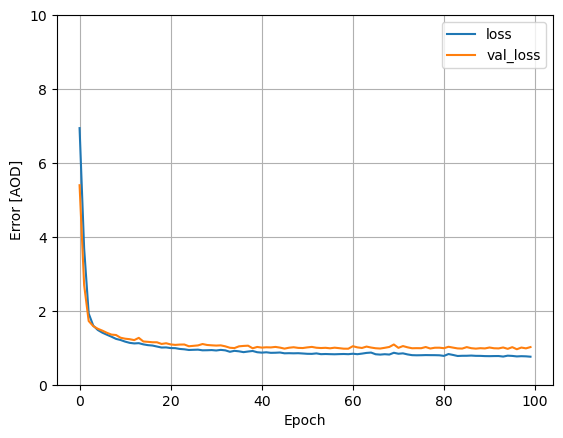

In [10]:
plt.clf()
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [AOD]')
  plt.legend()
  plt.grid(True)

plot_loss(history)
plt.show()


7/7 [==============================] - 0s 530us/step


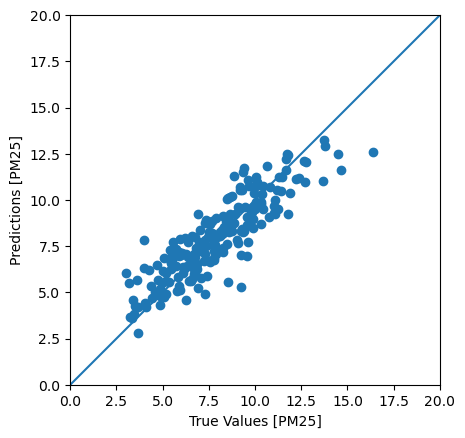

In [11]:
plt.clf()
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [PM25]')
plt.ylabel('Predictions [PM25]')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


plt.show()

In [12]:
test_predictions = dnn_model.predict(test_features).flatten()
test_predictions.shape

7/7 [==============================] - 0s 809us/step


(220,)

In [13]:
test_labels.shape

(220,)

In [14]:
mae = tf.keras.losses.MeanAbsoluteError()
mae(test_labels, test_predictions).numpy()

0.9305184

In [15]:
mse = tf.keras.losses.MeanSquaredError()
mse(test_labels, test_predictions).numpy()

1.4425116

In [16]:
#Get 2021 Data
data = r'/Users/bustergibson/documents/ml/pm25_aod_complete.csv'
dataset = pd.read_csv(data)
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]
dataset = dataset[dataset['YEAR'] == 2021]
dataset_2021 = dataset[['SITE_LATITUDE','SITE_LONGITUDE','YEAR','PM25','AOD']]
dataset_2021

,SITE_LATITUDE,SITE_LONGITUDE,YEAR,PM25,AOD
1100,41.170833,-73.194722,2021,8.133412,0.110507
1101,41.399167,-73.443056,2021,7.969359,0.128051
1102,41.784722,-72.631667,2021,8.001950,0.151212
1103,41.821342,-73.297257,2021,5.620872,0.212200
1104,41.301400,-72.902871,2021,7.798128,0.139341
...,...,...,...,...,...
1195,41.874668,-71.379971,2021,9.533728,0.128818
1196,41.841039,-71.360970,2021,7.125214,0.128818
1197,42.887590,-73.249840,2021,6.109695,0.125900
1198,44.528390,-72.868840,2021,4.380475,0.087533


In [17]:
#Create copies

features_2021 = dataset_2021.copy()

#Remove PM 2.5 because this is the variable we are trying to predict

labels_2021 = features_2021.pop('PM25')




4/4 [==============================] - 0s 1ms/step


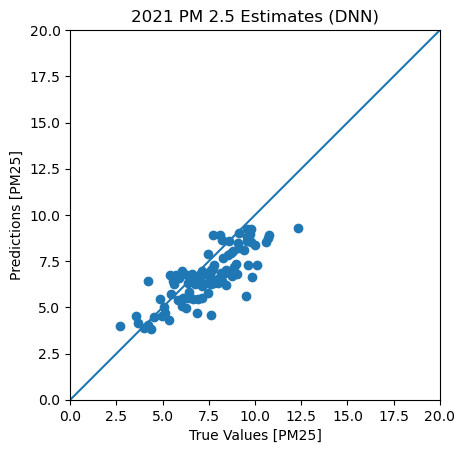

In [18]:
plt.clf()
predictions_2021 = dnn_model.predict(features_2021).flatten()

a = plt.axes(aspect='equal')
plt.scatter(labels_2021, predictions_2021)
plt.xlabel('True Values [PM25]')
plt.ylabel('Predictions [PM25]')
plt.title('2021 PM 2.5 Estimates (DNN)')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


plt.show()

In [19]:
mae = tf.keras.losses.MeanAbsoluteError()
mae(labels_2021, predictions_2021).numpy()

1.0558397

In [20]:
mse = tf.keras.losses.MeanSquaredError()
mse(labels_2021, predictions_2021).numpy()

1.713192